# Bus Stops by Neighborhood
### By Griffin Hurt

Dataset: [Port Authority Monthly On Time Performance by Route](https://data.wprdc.org/dataset/prt-of-allegheny-county-transit-stops)

Let's get started by loading in the neighborhood data with geopandas.

In [12]:
import geopandas as gpd
import pandas as pd

# Load in the neighborhoods
neighborhood_data = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')

neighborhood_data.head(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
0,1,233,42,003,140500,3,420031405003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7968760.0,a642a6b6-a2a9-48d5-acf2-3e2ce87d4bc0,8.153647e+06,14047.065024,"POLYGON ((-79.90560 40.45522, -79.90553 40.455..."
1,2,203,42,003,140100,3,420031401003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,34078712.0,20d4605b-258e-441a-a57e-a28fdabb6d30,3.407739e+07,30347.886823,"POLYGON ((-79.91309 40.43804, -79.91321 40.438..."
2,3,86,42,003,101700,2,420031017002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12751163.0,bf4065e7-c29c-48bd-b529-e7fd99077238,1.275116e+07,14577.441571,"POLYGON ((-79.93457 40.47217, -79.93455 40.472..."


We see that the neighborhood name is contained in the column labeled "hood" and the borders of the neighborhood are in "geometry". We can use the polygon object in "geometry" later to determine whether a bus stop is located in a neighborhood or not with `polygon.contains(stop)`.

Next we need to load in the bus stops.

In [15]:
# Load in the bus stops
stops = gpd.read_file('data/paac_stops_1909/PAAC_Stops_1909.shp')
# Filter stops to be bus stops only
stops = stops[stops["Mode"] == "Bus"]

stops.head(3)

,StopID,Stop_name,CleverID,Direction,Timepoint,Routes_ser,Routes_cou,Latitude,Longitude,Mode,Shelter,Stop_type,On_avwk_FY,Off_avwk_F,On_avwk__1,Off_avwk_1,AvgWkdy_De,geometry
0,E00175,26TH ST AT PENN AVE FS (SPRING WAY),2593.0,Inbound,N,"54, 88, 91",3.0,40.454635,-79.978170,Bus,No Shelter,Bus Stop,34.531580,43.900523,35,44,0.03,POINT (1348499.759 416298.200)
1,E00180,28TH ST AT LIBERTY AVE,2161.0,Inbound,N,54,1.0,40.456288,-79.974651,Bus,No Shelter,Bus Stop,1.304759,10.216890,1,10,0.03,POINT (1349493.900 416875.511)
2,E00270,32ND ST AT SPRING WAY,2410.0,Outbound,N,"54, 88, 91",3.0,40.460347,-79.969436,Bus,No Shelter,Bus Stop,13.184478,33.410865,13,33,0.04,POINT (1350981.820 418317.228)


It would be wonderful if the `Point` classes in the "geometry" column used latitude and longitude, but they don't, so we'll have to do that manually.

Next we're going to simplify the unwieldy geopandas dataset into a pandas dataset that is more manageable.

In [18]:

neighborhoods = pd.DataFrame(columns = ["Neighborhood", "Geometry", "Stops"])
neighborhoods["Neighborhood"] = neighborhood_data["hood"]
neighborhoods["Geometry"] = neighborhood_data["geometry"]
neighborhoods["Stops"] = 0

neighborhoods.head(3)

,Neighborhood,Geometry,Stops
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",0
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",0


Now we're ready to iterate through the bus stops and determine how many of them are in each neighborhood.

In [21]:
# Point class so we can fix the incorrect point geometry
from shapely.geometry import Point

for i, stop in stops.iterrows():
    # First, fix the point by using the correct latitude and longitude
    pt = Point(stop["Longitude"], stop["Latitude"])
    for j, neighborhood in neighborhoods.iterrows():
        # Check if the neighborhood has the stop
        if neighborhood["Geometry"].contains(pt):
            neighborhoods.at[j, 'Stops'] = neighborhood["Stops"] + 1
            # Break to save computation time
            break

neighborhoods.head(3)

,Neighborhood,Geometry,Stops
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",15
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",78
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",39


We can now sort the data in descending order by number of stops to see which neighborhood has the most stops.

In [25]:
neighborhoods_sorted = neighborhoods.sort_values("Stops", ascending=False)

neighborhoods_sorted.head(10)

,Neighborhood,Geometry,Stops
21,Lincoln-Lemington-Belmar,"MULTIPOLYGON (((-79.90496 40.48522, -79.90470 ...",95
52,Bloomfield,"POLYGON ((-79.94645 40.46547, -79.94621 40.465...",94
43,Central Business District,"POLYGON ((-79.99238 40.44484, -79.99233 40.444...",93
54,Mount Washington,"POLYGON ((-79.99927 40.42915, -79.99927 40.429...",86
75,Shadyside,"POLYGON ((-79.92238 40.46055, -79.92208 40.460...",82
80,Squirrel Hill South,"POLYGON ((-79.94475 40.44101, -79.94405 40.440...",81
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",78
83,Perry South,"POLYGON ((-80.01422 40.47745, -80.01435 40.477...",78
27,Greenfield,"POLYGON ((-79.92673 40.41886, -79.92692 40.418...",76
60,Hazelwood,"POLYGON ((-79.95505 40.42713, -79.95498 40.427...",71


We see that Lincoln-Lemington-Belmar is the neighborhood with the most bus stops. Let's plot the top 30 neighborhoods for fun.

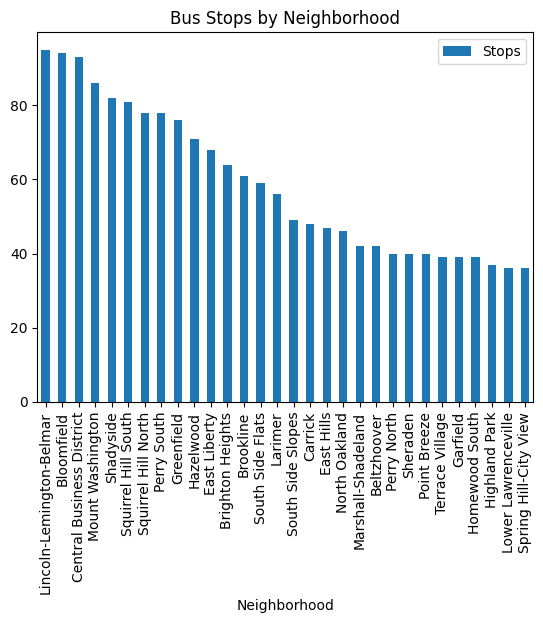

In [37]:
plt = neighborhoods_sorted.iloc[:30].plot(kind='bar', x="Neighborhood", y="Stops", title="Bus Stops by Neighborhood")

Let's also plot the bottom 30 neighborhoods.

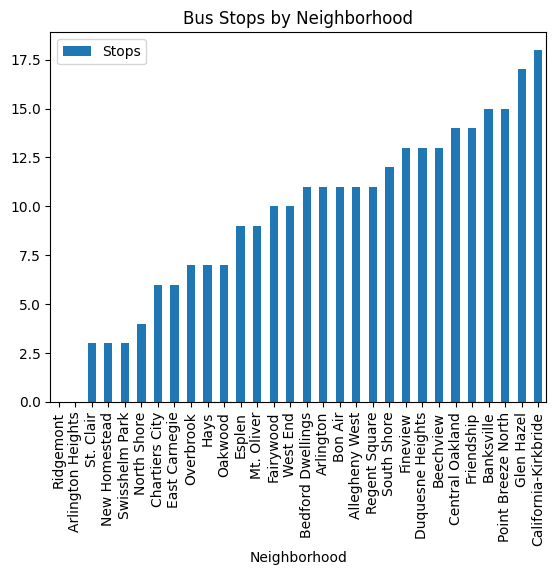

In [38]:
neighborhoods_asc = neighborhoods.sort_values("Stops")
plt2 = neighborhoods_asc.iloc[:30].plot(kind='bar', x="Neighborhood", y="Stops", title="Bus Stops by Neighborhood")

Finally, let's add bus stops to the original geodataframe and plot it.

<AxesSubplot: >

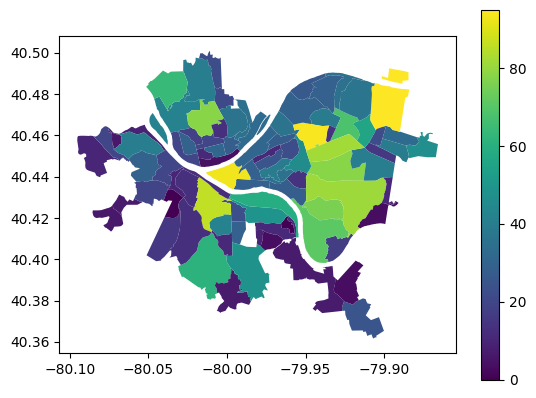

In [40]:
neighborhood_data["Bus_Stops"] = neighborhoods["Stops"]

neighborhood_data.plot(column="Bus_Stops", legend=True)

This concludes the analysis for the number of bus stops in each neighborhood.

# On Time Percentage by Neighborhood
### By Griffin Hurt

Dataset: [Pittsburgh Regional Transit Transit Stops](https://data.wprdc.org/dataset/port-authority-monthly-average-on-time-performance-by-route)

To quantify the on time percentage for a neighborhood, we want to look at the stops in that neighborhood concurrently with the on time percentage for the routes that run on those stops.

We first have to load in the on time percentage data.

In [43]:
otp_data = pd.read_csv("data/OTP_data.csv")

otp_data.head(5)

,route,ridership_route_code,route_full_name,current_garage,mode,month_start,year_month,day_type,on_time_percent,data_source
0,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,WEEKDAY,0.6837,Clever
1,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,SAT.,0.6977,Clever
2,1,001,1 - FREEPORT ROAD,Ross,Bus,2017-01-01,201701,SUN.,0.6280,Clever
3,2,002,2 - MOUNT ROYAL,Ross,Bus,2017-01-01,201701,WEEKDAY,0.6978,Clever
4,4,004,4 - TROY HILL,Ross,Bus,2017-01-01,201701,WEEKDAY,0.7438,Clever


We want to consolidate the data for each route, so we will create a new dataframe with all the routes and their overall average on time percentage.

In [54]:
# BLLB, BLSV, RED, BLUE, and SLVR are T lines, so exclude
excluded_routes = ["BLLB", "BLSV", "RED", "BLUE", "SLVR", float("NaN")]
otp_bus = otp_data.query("route not in @excluded_routes")
# Get all the unique route identifiers
route_identifiers = otp_bus.route.unique()
# Create a new pandas dataset for those routes and their on time percentages
otp_routes = pd.DataFrame(columns=["Route", "OTP_Sum", "OTP_Num_Obs"])
otp_routes["Route"] = route_identifiers
otp_routes["OTP_Sum"] = 0
otp_routes["OTP_Num_Obs"] = 0

for index, datapoint in otp_bus.iterrows():
    otp_routes.loc[otp_routes['Route'] == datapoint["route"], "OTP_Sum"] += datapoint["on_time_percent"]
    otp_routes.loc[otp_routes['Route'] == datapoint["route"], "OTP_Num_Obs"] += 1

# Calculate the average
otp_routes['OTP_Avg'] = otp_routes.apply(lambda row: row["OTP_Sum"] / row["OTP_Num_Obs"], axis=1)

otp_routes.head()


,Route,OTP_Sum,OTP_Num_Obs,OTP_Avg
0,1,124.6103,205,0.607855
1,2,78.7444,145,0.543065
2,4,107.5306,166,0.647775
3,6,151.8986,205,0.740969
4,7,50.9130,98,0.519520


Let's look at the best routes by average on time percentage.

In [55]:
otp_routes_sorted = otp_routes.sort_values("OTP_Avg", ascending=False)
otp_routes_sorted.head(5)

,Route,OTP_Sum,OTP_Num_Obs,OTP_Avg
72,G2,165.6887,205,0.808238
78,P1,165.2207,205,0.805955
19,26,159.4990,199,0.801503
20,27,156.9995,199,0.788942
27,40,154.6111,199,0.776940


Now we have to determine which routes pass through each neighborhood.

Brandon and I worked together on code that assigns each of the bus stops to a neighborhood. However, I made a slight change to this version so that if there are multiple stops in a neighborhood for a given route, the route is counted multiple times. That way, we can take a weighted average for the OTP of a neighborhood based on route frequency.

In [81]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load in the neighborhoods
neighborhood_gpd = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')
# Load in the bus stops
stops = gpd.read_file('data/paac_stops_1909/PAAC_Stops_1909.shp')
# Filter to only bus stops
stops = stops[stops['Mode'] == "Bus"]

# Our goal is to figure out which routes run through each neighborhood, so create a dataframe
neighborhoods = pd.DataFrame(columns=["Name", "Polygon", "Routes"])
neighborhoods["Name"] = neighborhood_gpd["hood"]
neighborhoods["Polygon"] = neighborhood_gpd["geometry"]
neighborhoods["Routes"] = [[] for _ in range(len(neighborhoods))]

for index, stop in stops.iterrows():
    # Create a point for the stop
    stop_point = Point(stop["Longitude"], stop["Latitude"])
    routes = stop["Routes_ser"].split(", ")
    # Loop through the neighborhoods
    for index2, neighborhood in neighborhoods.iterrows():
        if neighborhood["Polygon"].contains(stop_point):
            for route in routes:
                neighborhoods.at[index2, 'Routes'].append(route)
            break

neighborhoods.head(10)

,Name,Polygon,Routes
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 71D, 88, 74, 74, 74, 71C, 67, 69, 7..."
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 71B, 71D, 28X, 64, 71D, 28..."
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 8..."
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]"
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 54, 54, 54, 54, 44, 54, 54, 51, 54, 5..."
5,Homewood South,"POLYGON ((-79.88666 40.45521, -79.88651 40.455...","[77, 86, 77, 86, 77, 86, 77, 86, 77, 86, 77, 8..."
6,Middle Hill,"POLYGON ((-79.96534 40.44994, -79.96524 40.449...","[82, 81, 82, 81, 82, 81, 82, 81, 82, 82, 82, 8..."
7,Oakwood,"POLYGON ((-80.06322 40.42788, -80.06322 40.427...","[31, 31, 31, 31, 31, 31, 31]"
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 54, 71A, ..."
9,Duquesne Heights,"POLYGON ((-80.01774 40.43972, -80.01783 40.439...","[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4..."


Next, we want to calculate the on time percentage for each of the neighborhoods based on the routes that serve them.

In [85]:
neighborhoods["OTP_Sum"] = 0.0
neighborhoods["OTP_Count"] = 0

for i, neighborhood in neighborhoods.iterrows():
    for route in neighborhood["Routes"]:
        # Adds the route OTP to the average
        try:
            as_float = float(otp_routes.loc[otp_routes["Route"] == route, "OTP_Avg"])
            neighborhoods.at[i, "OTP_Sum"] += as_float
            neighborhoods.at[i, "OTP_Count"] += 1
        except:
            # In the case that this route is not present in the dataset, ignore it
            pass

# Calculate the average on time percentage
neighborhoods['OTP_Avg'] = neighborhoods.apply(lambda row: (row["OTP_Sum"] / row["OTP_Count"]) if row["OTP_Count"] != 0 else 0, axis=1)

neighborhoods.head(10)

,Name,Polygon,Routes,OTP_Sum,OTP_Count,OTP_Avg
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...","[71D, 28X, 71D, 88, 74, 74, 74, 71C, 67, 69, 7...",19.738214,31,0.636717
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...","[58, 71B, 71D, 28X, 71B, 71D, 28X, 64, 71D, 28...",126.007377,192,0.656288
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...","[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 8...",31.814873,44,0.723065
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]",7.419210,11,0.674474
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...","[54, 44, 54, 54, 54, 54, 44, 54, 54, 51, 54, 5...",25.269257,37,0.682953
5,Homewood South,"POLYGON ((-79.88666 40.45521, -79.88651 40.455...","[77, 86, 77, 86, 77, 86, 77, 86, 77, 86, 77, 8...",31.514936,49,0.643162
6,Middle Hill,"POLYGON ((-79.96534 40.44994, -79.96524 40.449...","[82, 81, 82, 81, 82, 81, 82, 81, 82, 82, 82, 8...",19.642823,30,0.654761
7,Oakwood,"POLYGON ((-80.06322 40.42788, -80.06322 40.427...","[31, 31, 31, 31, 31, 31, 31]",4.620841,7,0.660120
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...","[54, 71A, 71B, 71C, 71D, 75, 93, P3, 54, 71A, ...",125.124715,194,0.644973
9,Duquesne Heights,"POLYGON ((-80.01774 40.43972, -80.01783 40.439...","[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4...",10.100223,13,0.776940


Let's sort the data and plot the top 30 neighborhoods.

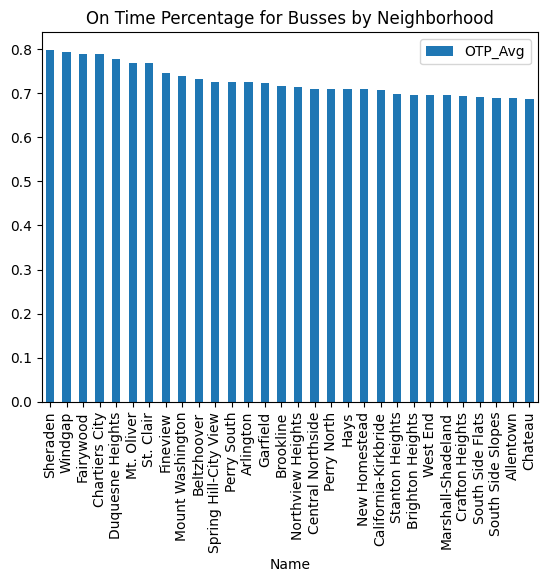

In [90]:
neighborhoods_sorted = neighborhoods.sort_values("OTP_Avg", ascending=False)

plt = neighborhoods_sorted.iloc[:30].plot(kind='bar', x="Name", y="OTP_Avg", title="On Time Percentage for Busses by Neighborhood")

Now let's look at the bottom 30 neighborhoods.

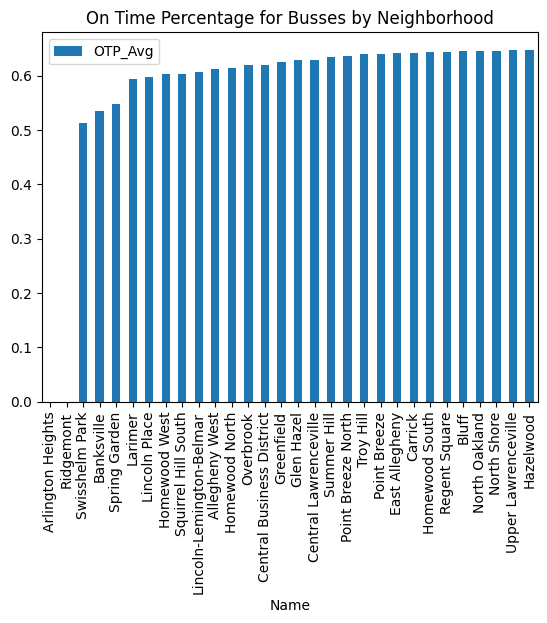

In [93]:
neighborhoods_sorted_asc = neighborhoods.sort_values("OTP_Avg")

plt2 = neighborhoods_sorted_asc.iloc[:30].plot(kind='bar', x="Name", y="OTP_Avg", title="On Time Percentage for Busses by Neighborhood")

Finally, let's plot the data on the map.

<AxesSubplot: >

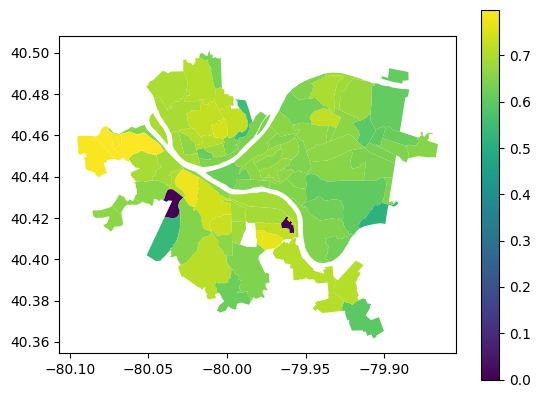

In [94]:
neighborhood_data["OTP_Avg"] = neighborhoods["OTP_Avg"]

neighborhood_data.plot(column="OTP_Avg", legend=True)

This concludes analysis of on time percentage by neighborhood.